In [1]:
# First importing the required packages:
%matplotlib inline
import sparse_ternary_networks.Tools as T
import sparse_ternary_networks.loadLab as load
import numpy as np
import sparse_ternary_networks.MLSTC as MLSTC
from scipy.linalg import eigh
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
##
import torch
from torch import nn
from torch.autograd import Variable
import sparse_ternary_networks.PyTorcher_MLSTC as STNetTorcher
# from RRQ.Tools import data_generator

In [2]:
# Initializing the parameters:
n = 512      # dimension
m = 512       # dimension of the codes
N_train = 10000     # number of samples for train set.
N_test = 10000
k = 2         # number of non-zero elements of the STC at each stage.
L = 2        # number of layer units of the network.
Rho = 0.9     # the coefficient of the AR(1) source.

In [3]:
# The covariance matrix of the AR(1) process with its toeplitz structure:
# cov_mat = toeplitz(Rho**np.arange(n))
# # Generating the train and test sets:
# F0_train = np.linalg.cholesky(cov_mat) @ np.random.randn(n,N_train)
# F0_test = np.linalg.cholesky(cov_mat) @ np.random.randn(n,N_test)
# # Normalization (scalar):
# # F0_train -= np.mean(F0_train)
# # F0_train /= np.std(F0_train)
# # #
# # F0_test -= np.mean(F0_test)
# # F0_test /= np.std(F0_test)

In [4]:
# MNIST loading, normalization and pre-processing:
data = np.load('Data/mnist.npz')
imgs_train = np.divide(data['imgs_train'],255).astype(float)
imgs_test = np.divide(data['imgs_test'],255).astype(float)
Y_train = data['Y_train']
Y_test = data['Y_test']
# Normalization:
imgs_train -= np.mean(imgs_train)
imgs_test -= np.mean(imgs_test)
#
imgs_train /= np.std(imgs_train)
imgs_test /= np.std(imgs_test)
nchannel = 1
imgs_resolution = (28,28,nchannel)
#
####################################################################################
# DCT:
F0_train = load.imgTensor2matrix_zigzagDCT(imgs_train,nchannel)
F0_test = load.imgTensor2matrix_zigzagDCT(imgs_test,nchannel)

In [5]:
# Pre-train the network with ML-STC:
#Learner = 'Random'
Learner = 'SuccessivePCA'
# Learner = 'ProcrusteanPCA'
obj_pre_train = MLSTC.BaseLearner(k,L,m=m,Learner=Learner)
_,_,_ = obj_pre_train.run(F0_train)

 ################## Starting to learn network parameters:  ##################
layer-units:
** 1 **** 2 **
Finished learning network parameters:


In [6]:
# Testing the pre-trained network:
obj_pre_test = MLSTC.fwdPass(obj_pre_train.params,k,ternaryProbMap=obj_pre_train.prob_z)
_,_,_ = obj_pre_test.run(F0_test)

 Running the network:
 ##################  Running the network:  ##################
layer-units:
** 1 **** 2 **
Finished running the network.


[0.         0.0096005  0.02170716]
[1.         0.48952824 0.38809186]


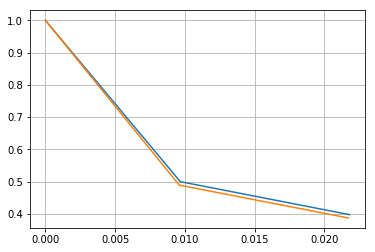

In [7]:
# Checking the pre-trained net.
plt.plot(obj_pre_train.rate,obj_pre_train.distortion)
plt.plot(obj_pre_test.rate,obj_pre_test.distortion)
plt.grid()
print(obj_pre_test.rate)
print(obj_pre_test.distortion)

In [8]:
# Torch hyper-params:
dtype = torch.FloatTensor
num_epoch = 4   
learning_rate = 1e-3  
num_batch = 1000
params = obj_pre_train.params
weight_decay = 0

In [9]:
# # Fine-tuning the compression model with back-propagation
obj_bp_train = STNetTorcher.fwdPass(params,k,nlinStrategy='KBest',beta_shape='scalar')
optimizer = torch.optim.Adam(obj_bp_train.parameters(), lr=learning_rate, weight_decay= weight_decay)
# ################################
F_torch = Variable(torch.from_numpy(np.copy(F0_train)).type(dtype))
counter = 0
for epoch in range(num_epoch):
    rand_perm = np.random.permutation(N_train)
    batch_map = []
    for iter in range(num_batch):
         batch_map.append(rand_perm[np.arange(iter*int(N_train/num_batch),(iter + 1)*int(N_train/num_batch) )])
    for iter in range(num_batch):        # gives batch data
        batch_map_current = batch_map[iter]
        F_minibatch = F_torch[:,batch_map_current]
        F_chapeau = obj_bp_train.forward(F_minibatch)

        loss = (F_minibatch - F_chapeau).pow(2).mean()
        if iter % 50 == 0:
            print('Epoch: ', epoch + 1, '| train loss: %.4f' % loss.data[0])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1

/home/sssohrab/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  1 | train loss: 0.2967
Epoch:  1 | train loss: 0.3586
Epoch:  1 | train loss: 0.3261
Epoch:  1 | train loss: 0.3360
Epoch:  1 | train loss: 0.3185
Epoch:  1 | train loss: 0.3541
Epoch:  1 | train loss: 0.3503
Epoch:  1 | train loss: 0.3604
Epoch:  1 | train loss: 0.4256
Epoch:  1 | train loss: 0.2845
Epoch:  1 | train loss: 0.3350
Epoch:  1 | train loss: 0.3554
Epoch:  1 | train loss: 0.3528
Epoch:  1 | train loss: 0.3057
Epoch:  1 | train loss: 0.3088
Epoch:  1 | train loss: 0.3015
Epoch:  1 | train loss: 0.3612
Epoch:  1 | train loss: 0.2834
Epoch:  1 | train loss: 0.2928
Epoch:  1 | train loss: 0.2827
Epoch:  2 | train loss: 0.3384
Epoch:  2 | train loss: 0.2728
Epoch:  2 | train loss: 0.2816
Epoch:  2 | train loss: 0.3450
Epoch:  2 | train loss: 0.2864
Epoch:  2 | train loss: 0.2091
Epoch:  2 | train loss: 0.3291
Epoch:  2 | train loss: 0.3275
Epoch:  2 | train loss: 0.3592
Epoch:  2 | train loss: 0.3160
Epoch:  2 | train loss: 0.2492
Epoch:  2 | train loss: 0.2861
Epoch:  

In [10]:
for l in range(L):
    obj_bp_train.params[l]['A'] /= np.linalg.norm(obj_bp_train.params[l]['A'],axis=1).reshape(-1,1)

In [11]:
# Running the fine-tuned compression network on the test set
obj_bp_test = MLSTC.fwdPass(obj_bp_train.params,k)  
_ = obj_bp_test.run(F0_test)

 Running the network:
 ##################  Running the network:  ##################
layer-units:
** 1 **** 2 **
Finished running the network.


[1.         0.48952824 0.38809186]
[1.         0.66774007 0.63965058]
[0.         0.0096005  0.02170716]
[0.         0.01273567 0.02762948]


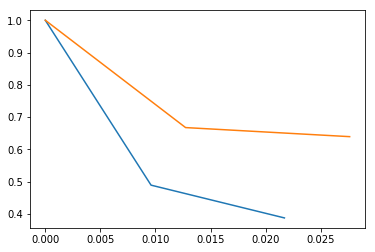

In [12]:
# Checking the distortion:
print(obj_pre_test.distortion)
print(obj_bp_test.distortion)
## 
print(obj_pre_test.rate)
print(obj_bp_test.rate)
#
plt.plot(obj_pre_test.rate,obj_pre_test.distortion)
plt.plot(obj_bp_test.rate,obj_bp_test.distortion)

In [13]:
# Re-adjusting beta:
obj_beta_train = MLSTC.BaseLearner(k, L,m=m,Learner='SuccessivePCA')
obj_beta_train.reRun_reweightUpdate(F0_train,obj_bp_train.params)
# Re-running on the final network:
obj_beta_test = MLSTC.fwdPass(obj_beta_train.params,k)  
_ = obj_beta_test.run(F0_test)

 ################## Starting to learn network parameters:  ##################
layer-units:
** 1 **** 2 **
Finished learning network parameters:
 Running the network:
 ##################  Running the network:  ##################
layer-units:
** 1 **** 2 **
Finished running the network.


[1.         0.48952824 0.38809186]
[1.         0.44087973 0.32493103]
[0.         0.0096005  0.02170716]
[0.         0.01273856 0.02822051]


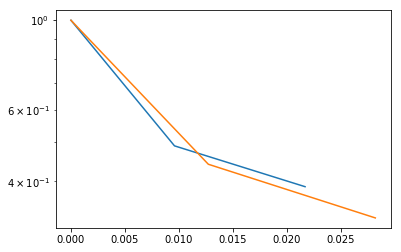

In [14]:
# Checking the distortion:

print(obj_pre_test.distortion)
print(obj_beta_test.distortion)
#
print(obj_pre_test.rate)
print(obj_beta_test.rate)
#
plt.semilogy(obj_pre_test.rate,obj_pre_test.distortion)
plt.semilogy(obj_beta_test.rate,obj_beta_test.distortion)

In [15]:
obj_pre_train.params[0]['beta'].T

array([[10.00132575,  9.54012311,  9.40415676,  9.39336437,  9.43795213,
         9.03990066,  9.02524561,  9.23480648,  9.05912796,  8.92805082,
         8.88267442,  8.82012412,  8.72661899,  9.30134598,  8.70578717,
         8.8123073 ,  8.89159477,  8.55436753,  8.619076  ,  9.27328095,
         8.77415501,  9.02042416,  8.91052319,  9.09635461,  8.8010356 ,
         9.0143566 ,  9.05117363,  8.82315634,  8.48975659,  8.57136572,
         8.42236658,  8.93332473,  8.47166896,  8.44896976,  8.46546488,
         7.9807092 ,  7.92700312,  8.27266984,  7.96844906,  8.32581966,
         7.96668172,  8.12388351,  8.38227226,  7.86197345,  7.98289325,
         7.84781731,  7.96813848,  7.89206631,  7.92505458,  7.93188852,
         7.9150042 ,  7.81364664,  7.82792745,  7.79124011,  7.77465244]])

In [16]:
obj_pre_train.params[0]['beta'].size

55